# Football Match Predictor - EDA and Data Cleaning

## Library Imports

In [1]:
# TODO: Add all the library imports required
import pandas as pd
import numpy as np
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt

## Download the data

In [2]:
!wget "https://aicore-files.s3.amazonaws.com/Data-Science/Football-Dataset.zip"

--2022-05-26 12:27:19--  https://aicore-files.s3.amazonaws.com/Data-Science/Football-Dataset.zip
Resolving aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)... 52.216.25.180
Connecting to aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)|52.216.25.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2204945 (2.1M) [application/zip]
Saving to: ‘Football-Dataset.zip’

Football-Dataset.zi 100%[===================>]   2.10M  3.13MB/s    in 0.7s    

2022-05-26 12:27:20 (3.13 MB/s) - ‘Football-Dataset.zip’ saved [2204945/2204945]



In [3]:
def import_league(league_name, df=None):
    if df is None:
        df = pd.DataFrame()
    years = list(range(1990,2022))
    
    for year in years:
        with ZipFile("Football-Dataset.zip") as myzip:
            data = myzip.open(f"Football-Dataset/{league_name}/Results_{year}_{league_name}.csv")
        season = pd.read_csv(data)
        season.columns = season.columns.str.lower()
        df = pd.concat([df, season])
    
    return df


def import_leagues(league_names):
    df = pd.DataFrame()
    for league in league_names:
        df = pd.concat([df, import_league(league)])
    return df

league_names = ["premier_league", "championship", "primera_division", "segunda_division",
                "bundesliga", "2_liga", "serie_a", "serie_b", "ligue_1", "ligue_2", 
                "eredivisie", "eerste_divisie"]

# Import the data into a single dataframe
data_df = import_leagues(league_names)
data_df.reset_index(inplace=True)
data_df.drop(['index'], axis=1, inplace=True)
data_df.rename(columns={'season': 'year', 'result': 'score'}, inplace=True)
data_df.tail() # Check to see if all the data is there

,home_team,away_team,score,link,year,round,league
129389,SC Telstar,FC Volendam,2-2,https://www.besoccer.com/match/stormvogels-tel...,2021,34,eerste_divisie
129390,Jong Ajax,Roda JC,0-4,https://www.besoccer.com/match/jong-ajax/roda-...,2021,34,eerste_divisie
129391,Dordrecht,Go Ahead Eagles,0-0,https://www.besoccer.com/match/fc-dordrecht/go...,2021,34,eerste_divisie
129392,Almere City,MVV Maastricht,0-0,https://www.besoccer.com/match/almere-city/mvv...,2021,34,eerste_divisie
129393,De Graafschap,Den Bosch,4-2,https://www.besoccer.com/match/graafschap/fc-d...,2021,34,eerste_divisie


## Clean the data

In [4]:
# Check that the score attribute contains two numerical values either side of the '-'
home_goals_numeric = data_df['score'].apply(lambda x: x.split('-')[0].isnumeric())
print(home_goals_numeric[~home_goals_numeric])


12293     False
86990     False
86992     False
101927    False
120300    False
Name: score, dtype: bool


In [5]:
data_df.loc[~home_goals_numeric]

,home_team,away_team,score,link,year,round,league
12293,Aston Villa,Everton,17 JAN,https://www.besoccer.com/match/aston-villa-fc/...,2021,19,premier_league
86990,Spezia,SSC Bari,3 (3-2) 2,https://www.besoccer.com/match/asd-spezia/as-b...,2013,18,serie_b
86992,Cittadella,Varese,0 (0-1) 1,https://www.besoccer.com/match/as-cittadella/a...,2013,18,serie_b
101927,Strasbourg,PSG,18 MAR,https://www.besoccer.com/match/strasbourg/pari...,2020,28,ligue_1
120300,PEC Zwolle,VVV Venlo,0 (0-0) 0,https://www.besoccer.com/match/fc-zwolle/vvv/2...,2013,15,eredivisie


In [6]:
# Manually clean the data
list_of_err_idxs = home_goals_numeric[~home_goals_numeric].index.to_list()
data_df.loc[list_of_err_idxs[4],'link']

data_df.loc[list_of_err_idxs[0],'score'] = '0-0'
data_df.loc[list_of_err_idxs[1],'score'] = '3-2'
data_df.loc[list_of_err_idxs[2],'score'] = '0-1'
# Fourth match postponed due to Covid pandemic so need to remove row
data_df.loc[list_of_err_idxs[4],'score'] = '0-0'

# Remove incompleted match
data_df.drop(list_of_err_idxs[3], inplace=True)

data_df.reset_index(inplace=True)
data_df.drop(['index'], axis=1, inplace=True)

In [7]:
# Check that the data cleaning has been done correctly
home_goals_numeric = data_df['score'].apply(lambda x: x.split('-')[0].isnumeric())
print(home_goals_numeric[~home_goals_numeric].sum())

0


### Create new features

In [8]:
# Split the home and away goals into separate attributes

home_goals_numeric = data_df['score'].apply(lambda x: x.split('-')[0].isnumeric())

data_df['home_goals'] = data_df['score'].apply(lambda x: int(x.split('-')[0]))
data_df['away_goals'] = data_df['score'].apply(lambda x: int(x.split('-')[1]))

def calculate_result(df):
    if df['home_goals'] > df['away_goals']:
        return 'home_win' # Home Win
    elif df['home_goals'] == df['away_goals']:
        return 'draw' # Draw
    else:
        return 'away_win' # Away Win


# New result attribute for each match
data_df['result'] = data_df[['home_goals', 'away_goals']].apply(calculate_result, axis=1)

print(data_df.shape)
data_df.head(10)

(129393, 10)


,home_team,away_team,score,link,year,round,league,home_goals,away_goals,result
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,0,0,draw
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,2,1,home_win
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,1,2,away_win
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,0,2,away_win
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,2,0,home_win
5,Nottingham Forest,Aston Villa,1-1,https://www.besoccer.com/match/nottingham-fore...,1990,1,premier_league,1,1,draw
6,Man. Utd,Arsenal,4-1,https://www.besoccer.com/match/manchester-unit...,1990,1,premier_league,4,1,home_win
7,Liverpool,Man. City,3-1,https://www.besoccer.com/match/liverpool/manch...,1990,1,premier_league,3,1,home_win
8,Coventry City,Everton,2-0,https://www.besoccer.com/match/coventry-city/e...,1990,1,premier_league,2,0,home_win
9,Wimbledon FC,Chelsea,0-1,https://www.besoccer.com/match/wimbledon-fc/ch...,1990,1,premier_league,0,1,away_win


## Find some high level relationships in the data

### Number teams in each league each year

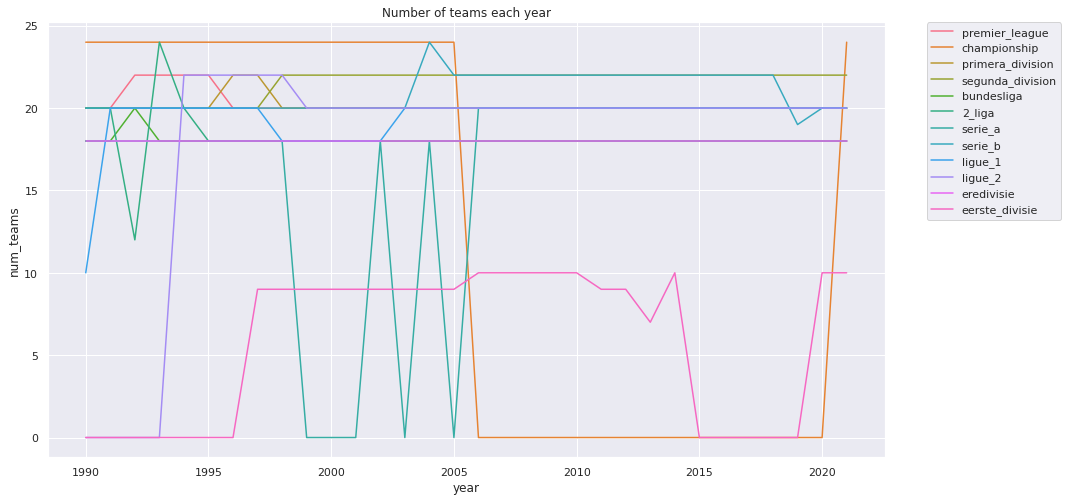

In [9]:
# How many teams in each league
# create a dataframe league, year, num_teams

year_df = []
league_df = []
num_teams_df = []
num_matches_df = []
num_goals_per_game_df = []
for league in league_names:
    for year in range(1990,2022):
        league_df.append(league)
        year_df.append(year)
        
        league_year_results = data_df[(data_df['league'] == league) & (data_df['year'] == year)]
        num_teams_df.append(league_year_results['home_team'].nunique())
        n_games = league_year_results.shape[0]
        num_matches_df.append(n_games)
        goals = league_year_results['home_goals'].sum()
        goals += league_year_results['away_goals'].sum()
        if n_games > 0:
            num_goals_per_game_df.append(goals/n_games)
        else:
            num_goals_per_game_df.append(0)

d1 = {"league": league_df, "year": year_df, "num_teams": num_teams_df}
d2 = {"league": league_df, "year": year_df, "num_matches": num_matches_df}
d3 = {"league": league_df, "year": year_df, "num_goals_per_game": num_goals_per_game_df}
how_many_teams_df = pd.DataFrame(d1)
how_many_matches_df = pd.DataFrame(d2)
how_many_goals_per_game_df = pd.DataFrame(d3)

# Plot the number of teams each year
sns.set(style="darkgrid")
plt.figure(figsize = (15,8))
sns.lineplot(x = 'year', y = 'num_teams', hue = 'league',
                data = how_many_teams_df).set(title='Number of teams each year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [10]:
# View the data in a dataframe

how_many_teams_wide = how_many_teams_df.pivot("year", "league", "num_teams")
how_many_teams_wide

league,2_liga,bundesliga,championship,eerste_divisie,eredivisie,ligue_1,ligue_2,premier_league,primera_division,segunda_division,serie_a,serie_b
year,,,,,,,,,,,,
1990,20,18,24,0,18,10,0,20,20,20,18,20
1991,20,18,24,0,18,20,0,20,20,20,18,20
1992,12,20,24,0,18,20,0,22,20,20,18,20
1993,24,18,24,0,18,20,0,22,20,20,18,20
1994,20,18,24,0,18,20,22,22,20,20,18,20
1995,18,18,24,0,18,20,22,22,20,20,18,20
1996,18,18,24,0,18,20,22,20,22,20,18,20
1997,18,18,24,9,18,20,22,20,22,20,18,20
1998,18,18,24,9,18,18,22,20,20,22,18,20


Seems to be plenty of missing data!!

### How many matches in each season

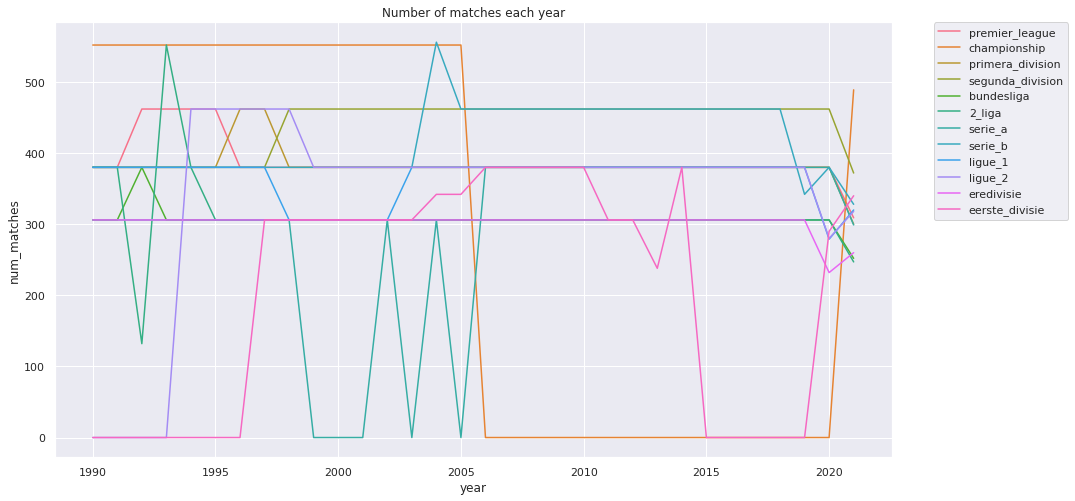

In [11]:
# How many matches in each season

# Plot the number of matches each year
plt.figure(figsize = (15,8))
sns.lineplot(x = 'year', y = 'num_matches', hue = 'league',
                data = how_many_matches_df).set(title='Number of matches each year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [12]:
# View the data in a dataframe

how_many_matches_wide = how_many_matches_df.pivot("year", "league", "num_matches")
how_many_matches_wide

league,2_liga,bundesliga,championship,eerste_divisie,eredivisie,ligue_1,ligue_2,premier_league,primera_division,segunda_division,serie_a,serie_b
year,,,,,,,,,,,,
1990,380,306,552,0,306,380,0,380,380,380,306,380
1991,380,306,552,0,306,380,0,380,380,380,306,380
1992,132,380,552,0,306,380,0,462,380,380,306,380
1993,552,306,552,0,306,380,0,462,380,380,306,380
1994,380,306,552,0,306,380,462,462,380,380,306,380
1995,306,306,552,0,306,380,462,462,380,380,306,380
1996,306,306,552,0,306,380,462,380,462,380,306,380
1997,306,306,552,306,306,380,462,380,462,380,306,380
1998,306,306,552,306,306,306,462,380,380,462,306,380


There seems to be some missing matches in 2020 due to the pandemic, also the 2021 season hasn't finished yet.

### Number of goals per game for each league each year

In [13]:
how_many_goals_per_game_wide = how_many_goals_per_game_df.pivot("year", "league", "num_goals_per_game")
how_many_goals_per_game_wide

league,2_liga,bundesliga,championship,eerste_divisie,eredivisie,ligue_1,ligue_2,premier_league,primera_division,segunda_division,serie_a,serie_b
year,,,,,,,,,,,,
1990,2.792105,2.581699,2.764493,0.000000,2.751634,2.600000,0.000000,2.594737,2.423684,2.028947,2.235294,1.773684
1991,2.623684,2.895425,2.682971,0.000000,2.712418,2.118421,0.000000,2.760526,2.163158,2.134211,2.294118,1.960526
1992,2.560606,2.615789,2.567029,0.000000,2.715686,2.094737,0.000000,2.541126,2.402632,2.160526,2.271242,1.947368
1993,2.597826,2.918301,2.625000,0.000000,2.934641,2.334211,0.000000,2.645022,2.510526,2.221053,2.803922,1.971053
1994,2.497368,2.924837,2.626812,0.000000,2.944444,2.236842,2.238095,2.586580,2.602632,2.421053,2.421569,2.060526
1995,2.816993,3.000000,2.516304,0.000000,3.205882,2.502632,2.294372,2.586580,2.542105,2.302632,2.526144,2.278947
1996,2.591503,2.715686,2.567029,0.000000,3.006536,2.281579,2.103896,2.600000,2.696970,2.331579,2.630719,2.260526
1997,2.686275,2.977124,2.673913,2.666667,2.823529,2.326316,2.186147,2.552632,2.751082,2.394737,2.640523,2.242105
1998,2.529412,2.885621,2.554348,2.888889,3.274510,2.359477,2.344156,2.681579,2.655263,2.162338,2.767974,2.357895


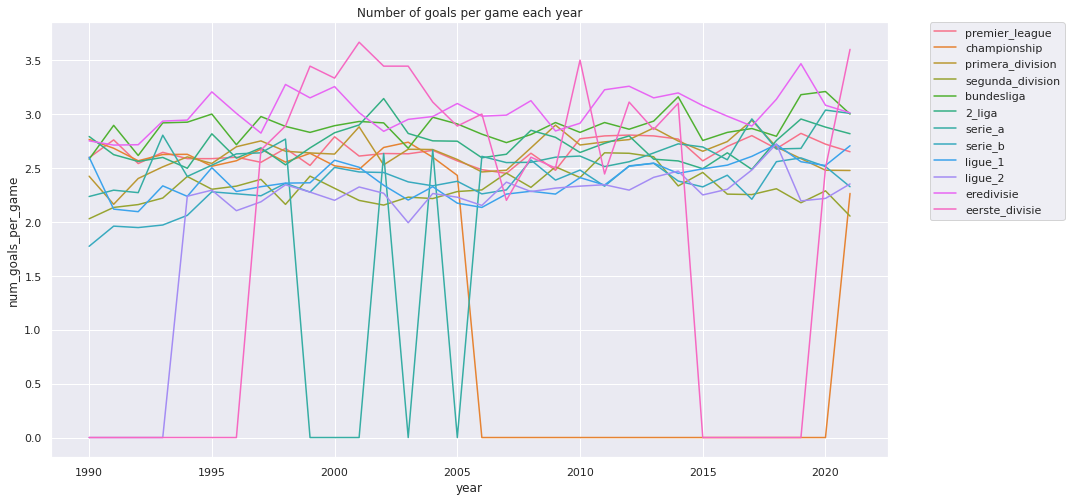

In [14]:
# How many goals per game for each season and league

# Plot the number of goals per game each year
plt.figure(figsize = (15,8))
sns.lineplot(x = 'year', y = 'num_goals_per_game', hue = 'league',
                data = how_many_goals_per_game_df).set(title='Number of goals per game each year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### Number of goals per game in each league

In [15]:
num_goals_per_game_league_df = []
for league in league_names:
    league_results = data_df[data_df['league'] == league]
    n_games = league_results.shape[0]
    goals = league_results['home_goals'].sum()
    goals += league_results['away_goals'].sum()
    if n_games > 0:
        num_goals_per_game_league_df.append(goals/n_games)
    else:
        num_goals_per_game_league_df.append(0)

d_goals_per_game = {'league': league_names, 'num_goals_per_game': num_goals_per_game_league_df}
how_many_goals_per_game_each_league_df = pd.DataFrame(d_goals_per_game)

how_many_goals_per_game_each_league_df

,league,num_goals_per_game
0,premier_league,2.651285
1,championship,2.587169
2,primera_division,2.636475
3,segunda_division,2.316356
4,bundesliga,2.880758
5,2_liga,2.709185
6,serie_a,2.629471
7,serie_b,2.330297
8,ligue_1,2.392123
9,ligue_2,2.291330


Text(0.5, 1.0, 'Number of goals per game in each league')

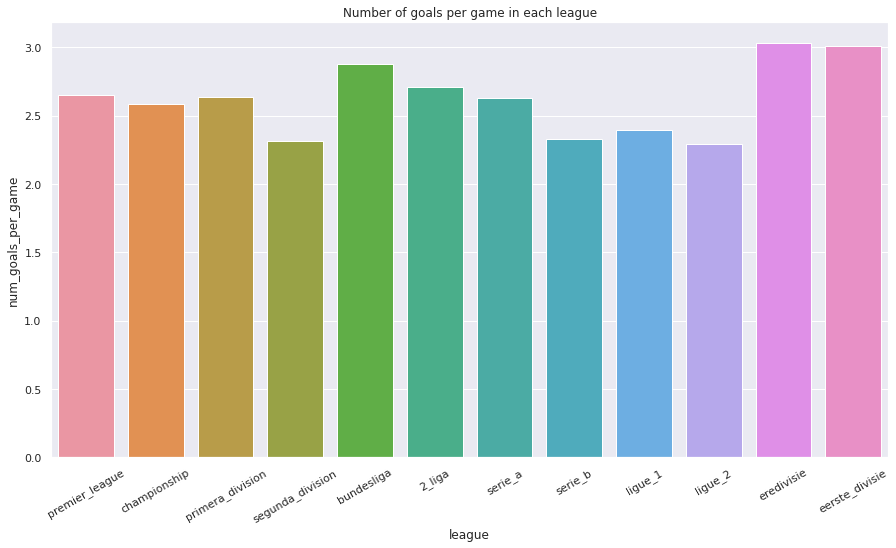

In [31]:
plt.figure(figsize = (15,8))
ax = sns.barplot(x="league", y="num_goals_per_game", data=how_many_goals_per_game_each_league_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title('Number of goals per game in each league')

Hmm, not much of interest in that statistic 

In [17]:
# Home and away goal split

num_goals_per_game_league_home = []
num_goals_per_game_league_away = []
for league in league_names:
    league_results = data_df[data_df['league'] == league]
    n_games = league_results.shape[0]
    home_goals = league_results['home_goals'].sum()
    away_goals = league_results['away_goals'].sum()
    if n_games > 0:
        num_goals_per_game_league_home.append(home_goals/n_games)
        num_goals_per_game_league_away.append(away_goals/n_games)
    else:
        num_goals_per_game_league_home.append(0)
        num_goals_per_game_league_away.append(0)

d_goals_per_game_home_away = {'league': league_names, 'num_goals_per_game_home': num_goals_per_game_league_home,
                                    'num_goals_per_game_away': num_goals_per_game_league_away}

how_many_goals_per_game_home_away_df = pd.DataFrame(d_goals_per_game_home_away)

how_many_goals_per_game_home_away_df

,league,num_goals_per_game_home,num_goals_per_game_away
0,premier_league,1.523556,1.127728
1,championship,1.500161,1.087008
2,primera_division,1.553414,1.083061
3,segunda_division,1.355250,0.961106
4,bundesliga,1.664289,1.216470
5,2_liga,1.581729,1.127456
6,serie_a,1.521303,1.108169
7,serie_b,1.375541,0.954756
8,ligue_1,1.434087,0.958036
9,ligue_2,1.356907,0.934423


Text(0.5, 1.0, 'Number of goals per game for each league for the home and away team')

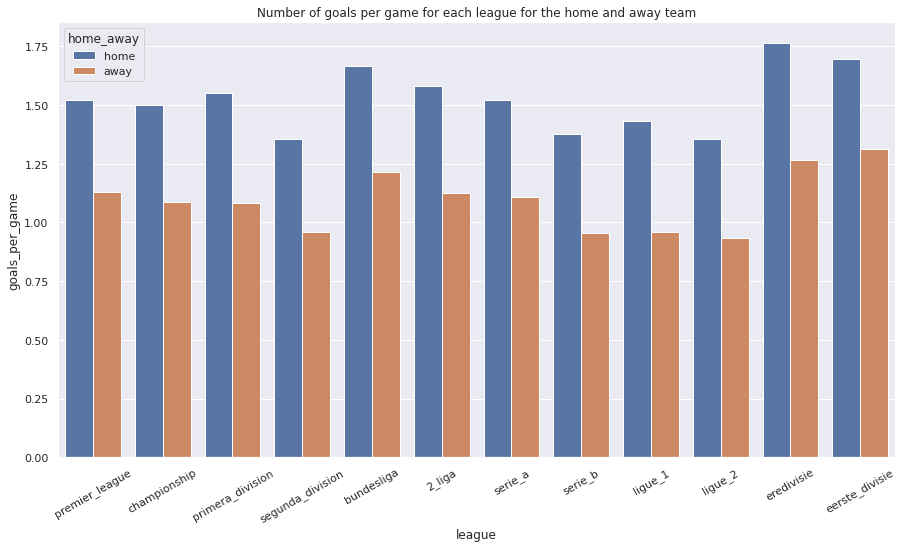

In [32]:
home_away_list = 12*['home'] + 12*['away']
how_many_goals_per_game_home_away_2_df = pd.DataFrame({'league': league_names*2,
                                            'goals_per_game': num_goals_per_game_league_home + num_goals_per_game_league_away, 'home_away': home_away_list,
                                            'sorted': [1,3,5,7,9,11,13,15,17,19,21,23,2,4,6,8,10,12,14,16,18,20,22,24]})
how_many_goals_per_game_home_away_2_df = how_many_goals_per_game_home_away_2_df.sort_values(by=['sorted'])
how_many_goals_per_game_home_away_2_df.drop('sorted', axis=1, inplace=True)
how_many_goals_per_game_home_away_2_df.reset_index(inplace=True)
how_many_goals_per_game_home_away_2_df.drop('index', axis=1, inplace=True)

plt.figure(figsize = (15,8))
ax = sns.barplot(x="league", y="goals_per_game", hue="home_away", data=how_many_goals_per_game_home_away_2_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title('Number of goals per game for each league for the home and away team')

Nice, there is an obvious relationship there between home and away goals. The away team scores much less goals than the home team, to be expected though but nonetheless still relevant.

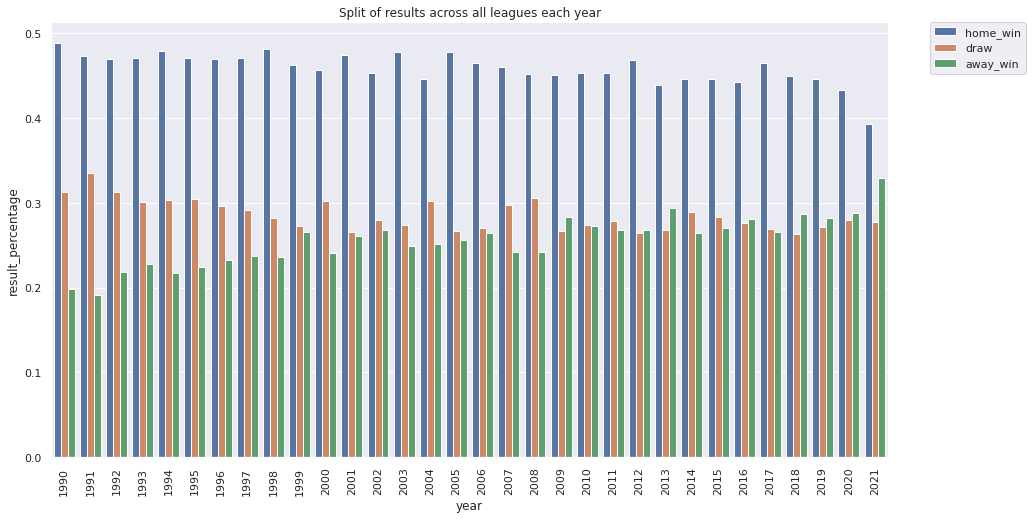

In [33]:
# Percentage of home/draw/away results year-by-year

home_wins_percentage = []
draws_percentage = []
away_wins_percentage = []

for year in range(1990,2022):
    year_results = data_df[data_df['year'] == year]
    n_games = year_results.shape[0]
    n_home_wins = year_results[year_results['result'] == 'home_win'].shape[0]
    n_draws = year_results[year_results['result'] == 'draw'].shape[0]
    n_away_wins = year_results[year_results['result'] == 'away_win'].shape[0]

    home_wins_percentage.append(n_home_wins/n_games)
    draws_percentage.append(n_draws/n_games)
    away_wins_percentage.append(n_away_wins/n_games)

how_many_wins_draws_df = pd.DataFrame({'year' : list(range(1990,2022)), 'home_win' : home_wins_percentage, 
                                        'draw' : draws_percentage, 'away_win' : away_wins_percentage})
how_many_wins_draws_df = how_many_wins_draws_df.melt(id_vars='year')
how_many_wins_draws_df = how_many_wins_draws_df.rename(columns={'variable': 'result', 'value': 'result_percentage'})

plt.figure(figsize = (15,8))
ax = sns.barplot(x="year", y="result_percentage", hue="result", data=how_many_wins_draws_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('Split of results across all leagues each year')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Not much has changed over the years although the percentage of away wins has steadily increased over the years.

## Download further data

In [20]:
!wget "https://aicore-files.s3.amazonaws.com/Data-Science/Match_Info.csv"
!wget "https://aicore-files.s3.amazonaws.com/Data-Science/Team_Info.csv"

--2022-05-26 12:28:02--  https://aicore-files.s3.amazonaws.com/Data-Science/Match_Info.csv
Resolving aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)... 52.217.165.169
Connecting to aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)|52.217.165.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14739082 (14M) [text/csv]
Saving to: ‘Match_Info.csv.1’

Match_Info.csv.1    100%[===================>]  14.06M  2.15MB/s    in 7.4s    

2022-05-26 12:28:10 (1.89 MB/s) - ‘Match_Info.csv.1’ saved [14739082/14739082]

--2022-05-26 12:28:11--  https://aicore-files.s3.amazonaws.com/Data-Science/Team_Info.csv
Resolving aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)... 52.217.101.172
Connecting to aicore-files.s3.amazonaws.com (aicore-files.s3.amazonaws.com)|52.217.101.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32367 (32K) [text/csv]
Saving to: ‘Team_Info.csv.1’

Team_Info.csv.1     100%[=============

In [21]:
match_info = pd.read_csv('Match_Info.csv', na_values=np.nan)
match_info.columns

Index(['Link', 'Date_New', 'Referee', 'Home_Yellow', 'Home_Red', 'Away_Yellow',
       'Away_Red'],
      dtype='object')

In [22]:
match_info.columns = match_info.columns.str.lower()
match_info.head(10)

,link,date_new,referee,home_yellow,home_red,away_yellow,away_red
0,/match/saarbrucken/stuttgarter-kickers/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Hans-Jürgen Weber\r\n,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Kurt Wittke\r\n,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Werner Föckler\r\n,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Heinz Werner\r\n,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Hans-Peter Dellwing\r\n,1.0,0.0,1.0,0.0
5,/match/hessen-kassel/blau-weiss-1890-berlin/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Hans-Joachim Osmers\r\n,2.0,0.0,3.0,1.0
6,/match/wattenscheid-09/bayreuth-spvgg/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Edgar Steinborn\r\n,0.0,0.0,1.0,0.0
7,/match/fortuna-koln/darmstadt-98/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Hans-Heinrich Barnick\r\n,0.0,0.0,1.0,0.0
8,/match/hertha-bsc/preuben-munster/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Hermann Albrecht\r\n,1.0,0.0,1.0,0.0
9,/match/eintracht-brau-hellip/hannover-96/1990,"Saturday, 29 July 1989, 15:00",\r\nReferee: Karl-Heinz Tritschler\r\n,2.0,0.0,2.0,0.0


In [23]:
# Need to clean the referee column
def clean_referee_col(item):
    try:
        remove_separators = item.split('\r\n')[1]
        ref_name = remove_separators.split(':')[1]
        ref_name_out = ref_name[1:]
        return ref_name_out
    except:
        if item == '\r\n':
            return np.nan
        else:
            return item

match_info['referee'] = match_info['referee'].apply(clean_referee_col)
match_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143348 entries, 0 to 143347
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   link         143348 non-null  object 
 1   date_new     143348 non-null  object 
 2   referee      113748 non-null  object 
 3   home_yellow  122798 non-null  float64
 4   home_red     122798 non-null  float64
 5   away_yellow  122798 non-null  float64
 6   away_red     122798 non-null  float64
dtypes: float64(4), object(3)
memory usage: 7.7+ MB


The missing data for yellow and red cards is going to have to be imputed, not sure how useful the referee column is likely to be.

In [24]:
match_info.describe()

,home_yellow,home_red,away_yellow,away_red
count,122798.000000,122798.000000,122798.000000,122798.000000
mean,1.729784,0.067469,2.096997,0.094684
std,1.350435,0.264917,1.440107,0.313102
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000
50%,2.000000,0.000000,2.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,10.000000,3.000000,10.000000,4.000000


In [25]:
team_info = pd.read_csv('Team_Info.csv', na_values=np.nan)
team_info.columns

Index(['Team', 'City', 'Country', 'Stadium', 'Capacity', 'Pitch'], dtype='object')

In [26]:
team_info.columns = team_info.columns.str.lower()
team_info.head(10)

,team,city,country,stadium,capacity,pitch
0,Wattenscheid 09,Bochum-Wattenscheid,Germany,Lohrheidestadion,16233,Natural
1,Hertha BSC,Berlín,Germany,Olympiastadion Berlin,76065,Natural
2,Unterhaching,Unterhaching,Germany,Sportpark Unterhaching,15053,Natural
3,Fortuna Köln,Cologne,Germany,Südstadion,14944,Natural
4,MSV Duisburg,Duisburgo,Germany,Schauinsland-Reisen-Arena,31514,Natural
5,Saarbrücken,Saarbrücken,Germany,Stadion Ludwigspark,35286,Natural
6,Braunschweig,Braunschweig,Germany,Eintracht-Stadion,23325,Natural
7,Hessen Kassel,Hessen,Germany,NaN,"18,737",grass
8,VfL Osnabrück,Osnabrück,Germany,osnatel-ARENA,16130,Césped
9,Meppen,Meppen,Germany,MEP-Arena,16500,Natural


In [27]:
team_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   team      544 non-null    object
 1   city      544 non-null    object
 2   country   544 non-null    object
 3   stadium   447 non-null    object
 4   capacity  544 non-null    object
 5   pitch     447 non-null    object
dtypes: object(6)
memory usage: 25.6+ KB


Some missing stadium and pitch data there, not sure they are needed anyway. The capacity data is all there so that is all that is needed.

In [28]:
team_info.describe()

,team,city,country,stadium,capacity,pitch
count,544,544,544,447,544,447
unique,544,464,7,442,448,16
top,Wattenscheid 09,Londres,Spain,Cartagonova,10000,Natural
freq,1,9,101,2,9,353
